In the training process were used next models:
<ul>
    <li>Ridge Regression</li>
    <li>Lasso Regression</li>
    <li>ElasticNet Regression</li>
    <li>Support Vector Machine</li>
    <li>Random Forest</li>
    <li>XG Boost</li>
</ul>

As a meta-regressor was used a XG Boost model 

<b>Submission score: 0.12496<b>

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import scipy.stats as stats
from sklearn.model_selection import train_test_split
%matplotlib inline

### Loading data

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


 ## Data Exploration & Preprocessing
 

## Removal of the outliers

<Figure size 640x480 with 0 Axes>

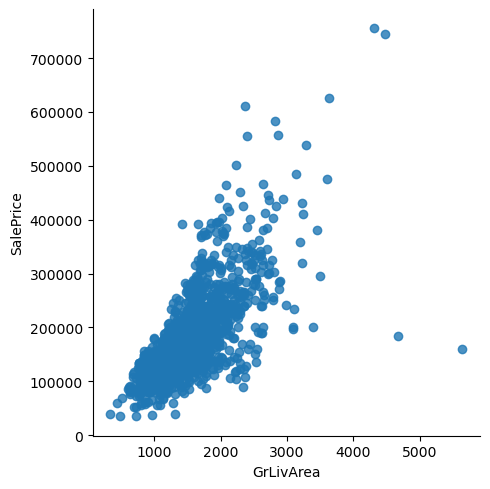

In [5]:
plt.figure()
otl = sns.lmplot(x='GrLivArea', y='SalePrice',data=train_df, fit_reg=False);

<Figure size 640x480 with 0 Axes>

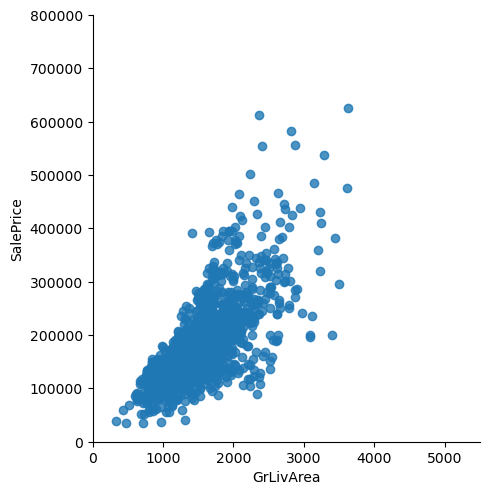

In [6]:
train_df.drop(train_df[(train_df['GrLivArea'] > 4000)].index,inplace=True)

plt.figure()
sns.lmplot(x='GrLivArea', y='SalePrice',data=train_df, fit_reg=False);
plt.xlim(0,5500);
plt.ylim(0,800000);

### Distribution

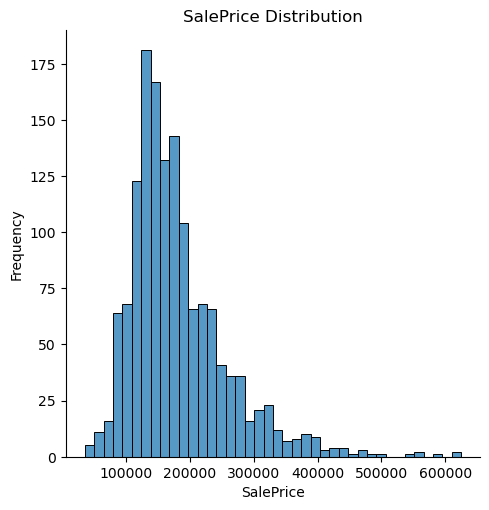

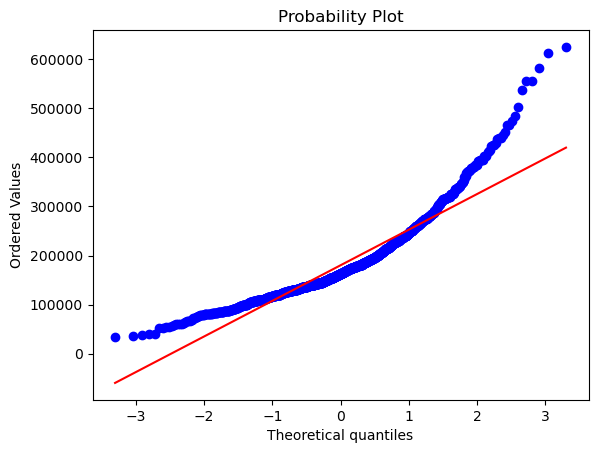

Skewness: 1.566


In [7]:
sns.displot(train_df['SalePrice'])
plt.title('SalePrice Distribution')
plt.ylabel('Frequency')

plt.figure()
qq = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

# For normally distributed data, the skewness should be about zero. 
# A skenewss  value greater than zero means that there is more weight in the left tail of the distribution

print("Skewness: {:.3f}".format(train_df['SalePrice'].skew()))

From the plots above we can see, that the target variable is skewed to the right. In order to use many general linear models, we need to transform it to normal.

### Target variable transformation

In [8]:
# log1p calculates log(1 + input)

train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

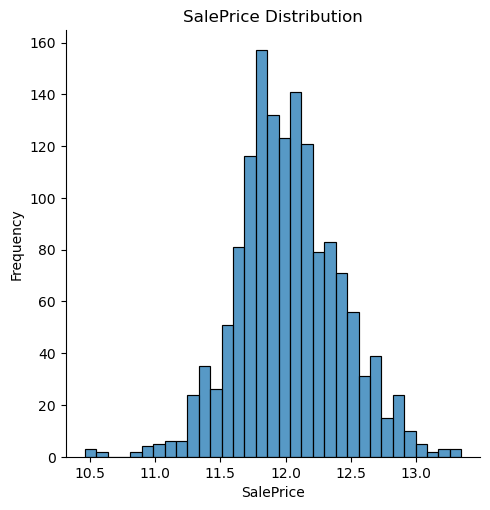

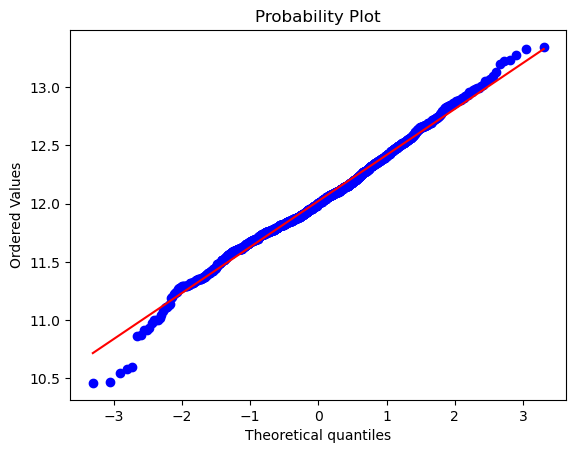

Skewness: 0.065


In [9]:
# check the result of the transformation

sns.displot(train_df['SalePrice'])
plt.title('SalePrice Distribution')
plt.ylabel('Frequency')

plt.figure()
qq = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

print("Skewness: {:.3f}".format(train_df['SalePrice'].skew()))

### Correlation check

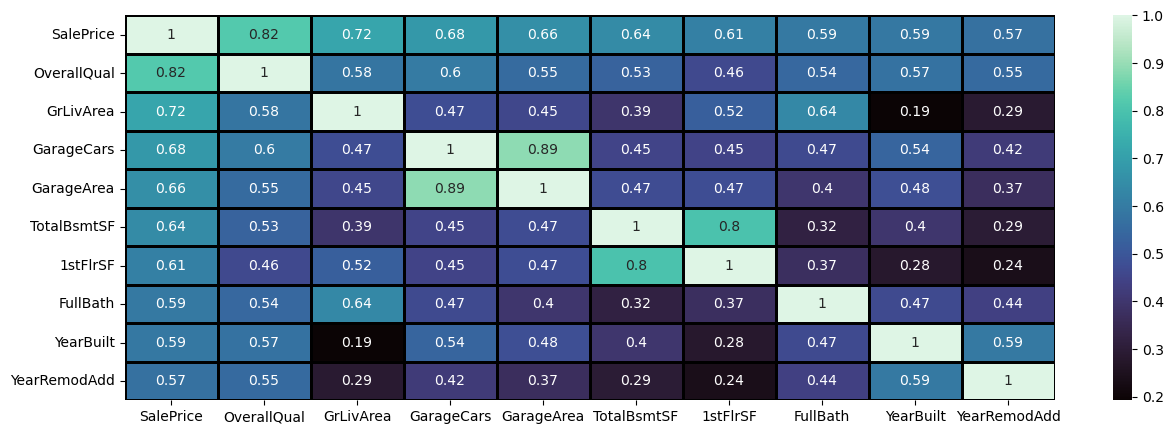

In [10]:
plt.figure(figsize=(15,5))

# correlation table
corr_train = train_df.corr()

# select top 10 highly correlated variables with SalePrice
num = 10
col = corr_train.nlargest(num, 'SalePrice')['SalePrice'].index
coeff = np.corrcoef(train_df[col].values.T)

# heatmap
heatmp = sns.heatmap(coeff, annot = True, xticklabels = col.values, yticklabels = col.values, linewidth=2,cmap=sns.color_palette("mako", as_cmap=True), linecolor='black')
# heatmp = sns.heatmap(coeff, annot = True, xticklabels = col.values, yticklabels = col.values, linewidth=2,cmap='PiYG', linecolor='blue')

Based on the correlation table shown, we can conjecture that the features related with quality (OverallQual,FullBath, YearBuilt, YearRemodAdd) and the size (GrLivArea, GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF) may play an important role in prediction.

### Pairplot

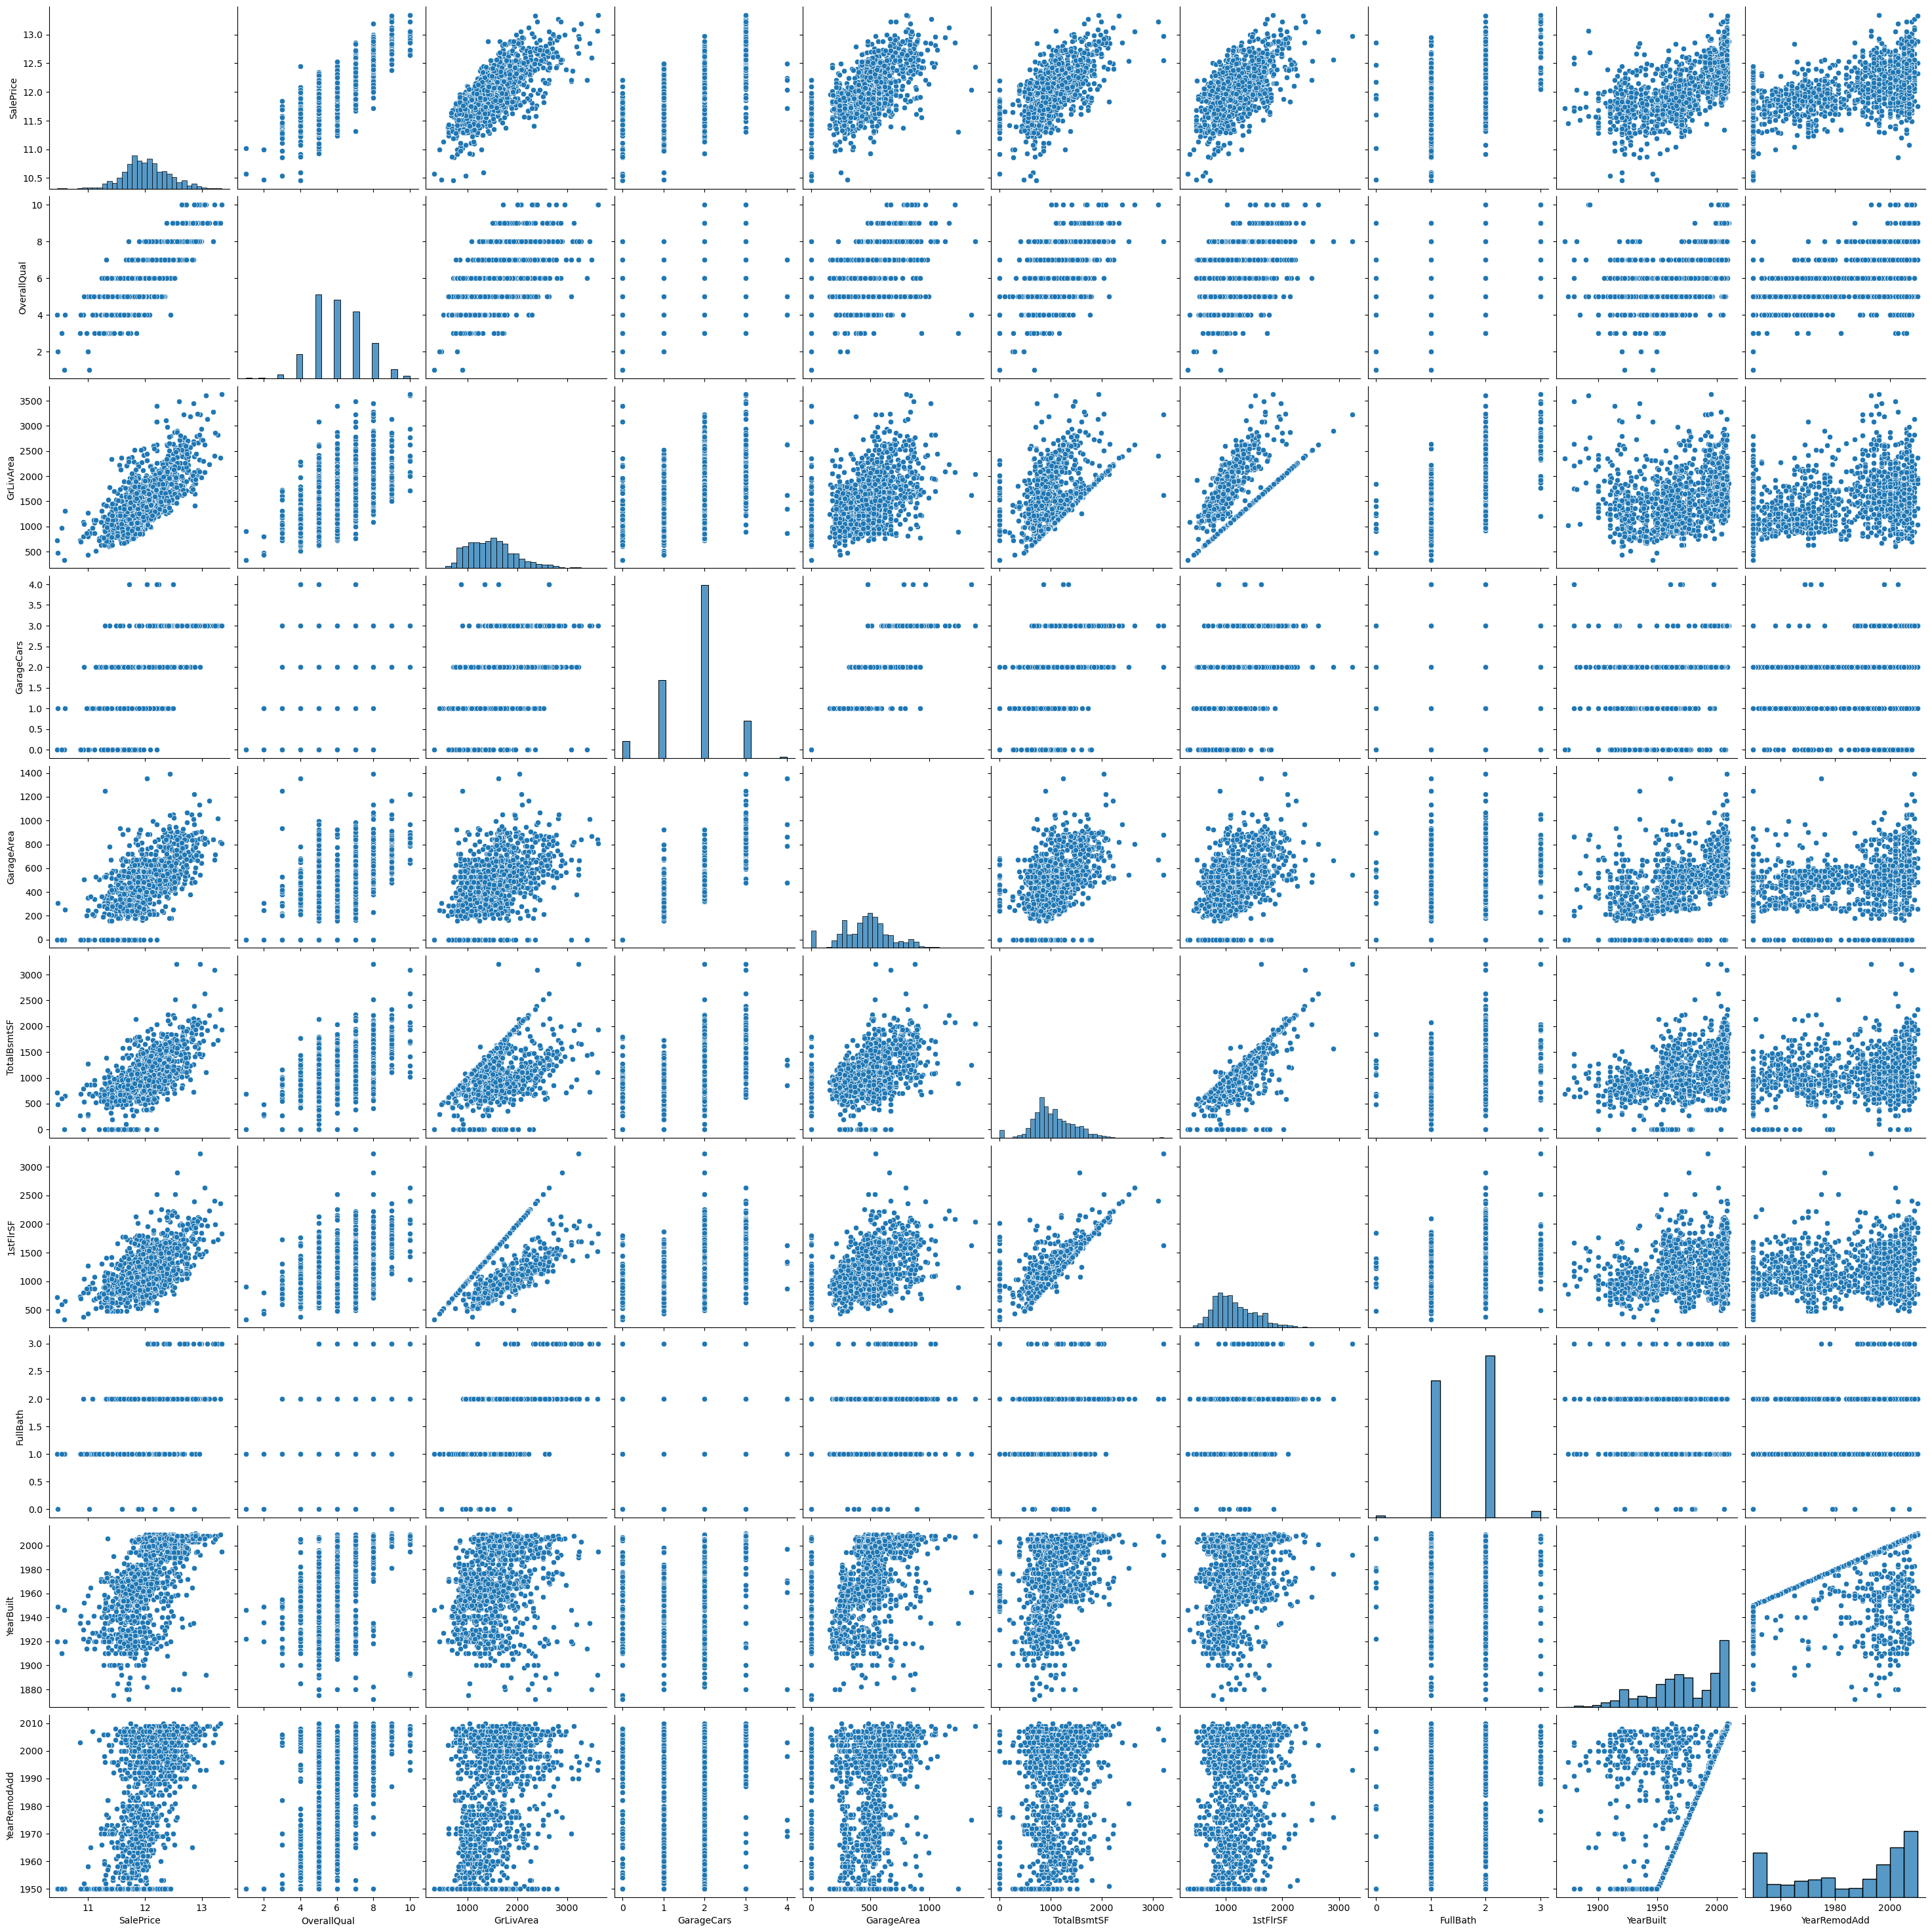

In [11]:
# Visualized the relationship between the target variable and top 10 features highly correlated with the target variable.

sns.pairplot(train_df[col], height=3);

As we can see the first column of the plots, it is not perfectly linear but we can say some of them are showing some positive linear pattern.

### Independent Variables (Id, SalePrice) Seperation

In [12]:
# seperate id from datasets and drop them.

train_id = train_df.iloc[:,0]
test_id = test_df.iloc[:,0]

train_df.drop('Id',axis=1,inplace = True)
test_df.drop('Id',axis=1,inplace = True)

In [13]:
# seperate the target variable (SalePrice) from the train

y_df = train_df['SalePrice']
train_df.drop('SalePrice',axis=1,inplace=True)

print('dimension of the train:' , train_df.shape)
print('dimension of the test:' , test_df.shape)

dimension of the train: (1456, 79)
dimension of the test: (1459, 79)


### Concatenation of train and test datasets

In [14]:
# In order to avoid repeating unnecessary codes, for our convenience, let's combine the train and test set.
df = pd.concat([train_df, test_df]).reset_index()

df.drop(['index'],axis=1,inplace=True)

In [15]:
print('dimension of the dataset:' , df.shape)
df.head()

dimension of the dataset: (2915, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


## Feature engineering

### Missing values

In [16]:
# check for missing values

mc = pd.DataFrame(df.isnull().sum(),columns=['Missing Count'])
mc = mc[mc['Missing Count']!=0]
mc['Missing %'] = (mc['Missing Count'] / df.shape[0]) * 100
mc.sort_values('Missing %',ascending=False)

,Missing Count,Missing %
PoolQC,2907,99.725557
MiscFeature,2810,96.397942
Alley,2717,93.207547
Fence,2345,80.445969
FireplaceQu,1420,48.713551
LotFrontage,486,16.672384
GarageFinish,159,5.454545
GarageQual,159,5.454545
GarageCond,159,5.454545
GarageYrBlt,159,5.454545


<b>Nones</b><br>
The data documentation says missing values in the above features (the elements in the list "nones") mean these properties do not have one of them: garage, basment, fireplace, alley access, pool, misc features, fence, or masonry veneer.

In [17]:
nones = ['PoolQC', 'MiscFeature', 'Alley','Fence', 'FireplaceQu', 'GarageType','GarageFinish',
        'GarageQual','GarageCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
        'MasVnrType']

for none in nones:
    df[none].fillna('None',inplace = True)

<b>Zeros</b><br>
Some features are explicitly described that the missing values mean zero or we can assume that these properties have zero basement or garage or masonry veneer.

In [18]:
zeros = ['GarageYrBlt','GarageArea','GarageCars','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
         'BsmtFullBath','BsmtHalfBath','MasVnrArea']

for zero in zeros:
    df[zero].fillna(0, inplace = True)

<b>Removal</b><br>
As you can see below, there are only two categories in the Utilities feature: 'AllPub' and 'NoSeWa'. Moreover, except 1 'NoSeWa and 2 NaN values, all the values are 'AllPub' ,which means the data is very imbalanced and this feature seems not that helpful in predictive modeling. I decide to remove this feature.

In [19]:
Counter(df.Utilities)

Counter({'AllPub': 2912, 'NoSeWa': 1, nan: 2})

In [20]:
df.drop('Utilities',axis=1, inplace=True)

<b>Mode</b><br>
Unlike Utilities feature, the features below are not extremly imbalanced and consist of many categories. Also, there are only a few missing values in each feature. Therefore, we can fill missing values with most frequently occurred values.

In [21]:
freq = ['MSZoning','Exterior1st','Exterior2nd','SaleType','Electrical','KitchenQual','Functional']

for fr in freq:
    df[fr].fillna(df[fr].mode()[0], inplace=True)

<b>Groupby</b><br>
Since there are a lot of missing values in the LotFrontage, simply filling in missing values with median or mode may affect badly our models. We can fill missing values in LotFrontage with the median LotFrontage of similar rows according to LotArea and Neighborhood.

In [22]:
df['old_lotfrontage'] = df['LotFrontage']

df['LotFrontage'] = df.groupby(['LotArea','Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

c:\Users\Solega\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Solega\miniconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


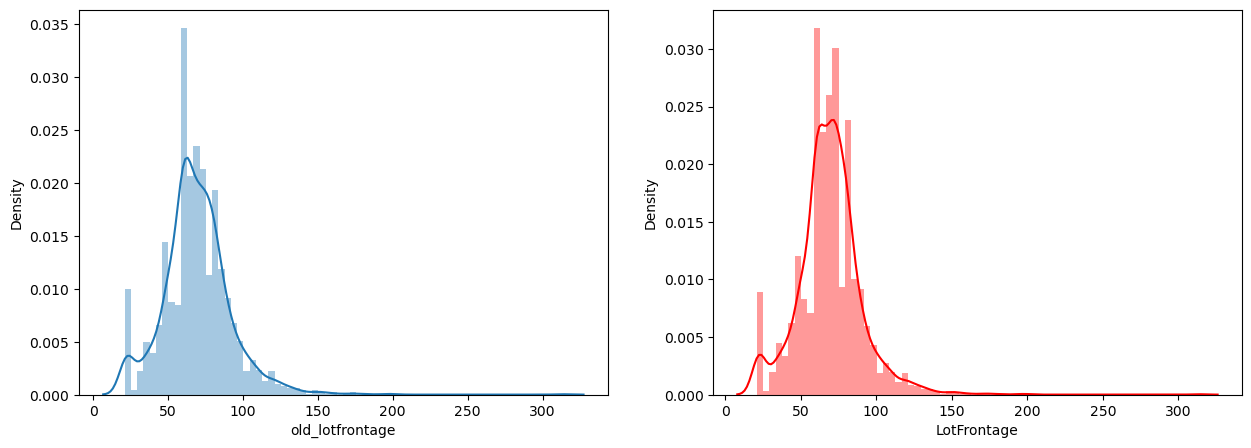

In [23]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ol = sns.distplot(df['old_lotfrontage'].dropna(),ax=ax1,kde=True,bins=70)
lf = sns.distplot(df['LotFrontage'],ax=ax2,kde=True,bins=70,color='red')

# drop the old_lotfrontage as we finished the comparison
df.drop('old_lotfrontage',axis=1,inplace=True)

The left blue plot is the distribution of the 'LotFrontage' from original dataset after simply omitting missing values and the right red plot is the distribution of the 'LotFrontage' after filling missing values with the median ages of similar rows. As you can see, the distributions are very similar each other.

In [24]:
print("Remaining missing values:",df.isnull().sum().sum())

Remaining missing values: 0


### Transformation and encoding

### Nominal
Machine learning algorithms will require that nominal variables be converted into dummy variables (0 or 1) as all of scales are mutually exclusive (no overlap) and none of them have any numerical significance.

In [25]:
# get_dummies can convert data to 0 and 1 only if the data type is string. Among the many nominal features,
# MSSubClass, MoSold, and YrSold are integer type so we need to convert them to string type.

df['MoSold'] = df['MoSold'].astype(str)
df['YrSold'] = df['YrSold'].astype(str)
df['MSSubClass'] = df['MSSubClass'].astype(str)

nominals = ['MSSubClass','MSZoning','Street','Alley','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl',
           'Exterior1st','Exterior2nd','MasVnrType','Foundation','Heating','CentralAir','GarageType','MiscFeature','SaleType','SaleCondition','MoSold','YrSold']

### Ordinal
With ordinal scales, it is the order of the values is what's important and significant, but the differences between each one is not really known. Therefore, unlike nominal, ordinal values matter the order (e.g. a > b > c). In this case, instead of using get_dummies (0 or 1), it is better to use LabelEncoder.

In [26]:
from sklearn.preprocessing import LabelEncoder

ordinals = ['LotShape','LandSlope','OverallQual','OverallCond','ExterQual','ExterCond','BsmtQual',
           'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','Electrical','KitchenQual',
            'Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence']

for ordinal in ordinals:
    le = LabelEncoder()
    le.fit(df[ordinal])
    df[ordinal] = le.transform(df[ordinal])

### New feature
As we have seen the correlation table, area features such as GrLivArea or BsmtSF are highly correlated with house sales price. Creating new feature regarding the total area may help predict the target variable.

In [27]:
# Total square feet of houses

df['totalArea'] = df['GrLivArea'] + df['TotalBsmtSF']

### Skewed numeric features

In [28]:
# Assign numeric features by excluding non numeric features
numeric = df.dtypes[df.dtypes != 'object'].index

# Display the skewness of each column and sort the values in descending order 
skewness = df[numeric].apply(lambda x: x.skew()).sort_values(ascending=False)

# Create a dataframe and show 5 most skewed features 
sk_df = pd.DataFrame(skewness,columns=['skewness'])
sk_df['skw'] = abs(sk_df)
sk_df.sort_values('skw',ascending=False).drop('skw',axis=1).head()

,skewness
PoolQC,-22.996032
MiscVal,21.943440
PoolArea,18.711459
LotArea,13.130516
LowQualFinSF,12.086535


Skewnewss quantifies how symmetrical the distribution is:
<ul>
<li>If skewness is less than -1 or greater than 1, the distribution is highly skewed.</li>
<li>If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.</li>
<li>If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.</li>
</ul>

### Log1p transformation

In [29]:
# As a general rule of thumb, skewness with an absolute value less than 0.5 is considered as a acceptable range of skewness for normal distribution of data
skw_feature = skewness[abs(skewness) > 0.5].index

# Transform skewed features to normal distribution by taking log(1 + input)
df[skw_feature] = np.log1p(df[skw_feature])

### Dummy variable
A dummy variable is one that takes the value 0 or 1 to indicate the absence or presence of some categorical effect that may be expected to shift the outcome. Since 'get_dummies' function does not affect numerical values, only nominal data type values will be converted to 0 or 1 (as we already converted ordinal types values to numeric by LabelEncoder, we do not have to worry about that).

In [30]:
df = pd.get_dummies(df)
print(df.shape)

(2915, 250)


### Train test split
Since data cleaning and feature engineering process are finished, we need to split the combined dataset into train and test as given dataset

In [31]:
# Split the combined dataset into two: train and test

X_train = df[:train_df.shape[0]]
X_test = df[train_df.shape[0]:]

#X_train, X_test, y_train, y_test = train_test_split(df,y_df, random_state = 1)

In [32]:
print("training shape:{}, test shape:{}".format(X_train.shape,X_test.shape))

training shape:(1456, 250), test shape:(1459, 250)


## Modeling

In [ ]:
# Import libraries

from sklearn.model_selection import GridSearchCV,learning_curve, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error

from sklearn.linear_model import LassoCV,ElasticNetCV,Lasso,ElasticNet
from sklearn.kernel_ridge import KernelRidge

from mlxtend.regressor import StackingRegressor
from xgboost import XGBRegressor

In [34]:
print(X_train.shape, X_test.shape,y_df.shape)

(1456, 250) (1459, 250) (1456,)


### Feature scaling
Many machine learning algorithms expect the scale of the input and even the output data to be equivalent. It can help in methods, particularly linear models, that weights in order to make a prediction. Among many scaling techniques, I decided to use StandardScaler since in the previous section 3.1.1 outlier detections, we have already removed the data whose GrLivArea is greater than 4000. Therefore, we would worry the information loss by removing the outliers more rather than distortion of the data shape because of outliers. If we did not delete those outliers, it would be better to choose RobustScaler.

In [35]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
#X_train = RobustScaler().fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = df.columns )

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = df.columns)
#X_test = RobustScaler().fit_transform(X_test)

In [36]:
y_df.head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

### Simple modeling

### Kfold

In [37]:
kfold = KFold(n_splits=20, random_state= 0, shuffle = True)

### Score

In [38]:
def rmsle_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_df, scoring="neg_mean_squared_error", cv = kfold))
    return(rmse)

### Kernel Ridge

In [39]:
KR = KernelRidge()

KR_param_grid = {
    'alpha' : [0.93],
    'kernel' : ['polynomial'],
    'gamma':[0.001],
    'degree': [3],
    'coef0': [1.5]
}

KR_CV = GridSearchCV(KR, param_grid = KR_param_grid, cv = kfold, scoring = "neg_mean_squared_error",n_jobs = -1, verbose = 1)
KR_CV.fit(X_train, y_df)
KR_best = KR_CV.best_estimator_
print(KR_best)

# scaler, cv = 20
# * KernelRidge(alpha=1.0, coef0=0.9, degree=2, gamma=0.004, kernel='polynomial',kernel_params=None)
# ** KernelRidge(alpha=0.93, coef0=1.5, degree=3, gamma=0.001, kernel='polynomial',kernel_params=None)
# *** KernelRidge(alpha=0.93, coef0=1.5, degree=3, gamma=0.001, kernel='polynomial',kernel_params=None) - 0.12514

Fitting 20 folds for each of 1 candidates, totalling 20 fits
KernelRidge(alpha=0.93, coef0=1.5, gamma=0.001, kernel='polynomial')


In [40]:
y_submission_1 = np.expm1(KR_best.predict(X_test))

In [41]:
score = rmsle_cv(KR_best)
print("Kernel Ridge mean score:", score.mean())
print("Kernel Ridge std:", score.std())

Kernel Ridge mean score: 0.11243738482886687
Kernel Ridge std: 0.019533979358615422


### Lasso Regression

In [42]:
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0005, 0.0008, 0.001, 0.003, 0.007, 0.009, 0.01, 0.03, 0.05, 0.07, 0.09, 0.2, 0.4, 0.6, 0.8, 1, 1.2], random_state = 1, n_jobs = -1, verbose = 1)
lasso.fit(X_train, y_df)
alpha = lasso.alpha_
print("Optimized Alpha:", alpha)

lasso = LassoCV(alphas = alpha * np.linspace(0.5,1.5,20), cv = kfold, random_state = 1, n_jobs = -1)
lasso.fit(X_train, y_df)
alpha = lasso.alpha_
print("Final Alpha:", alpha)

# scaler cv = 20
#lasso = LassoCV(alphas = 0.00244736842105, cv = kfold, random_state = 1, n_jobs = -1, verbose = 1)
#lasso.fit(X_train, y_df)

#Final Alpha: 0.00244736842105

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
............................................................................................[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
...[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Optimized Alpha: 0.003
Final Alpha: 0.002605263157894737


In [43]:
print("Lasso mean score:", rmsle_cv(lasso).mean())
print("Lasso std:", rmsle_cv(lasso).std())

Lasso mean score: 0.11147345000927004
Lasso std: 0.02191330034177913


### Elastic Net Regression

In [44]:
y_submission_2 = np.expm1(lasso.predict(X_test))

In [ ]:
elnet = ElasticNetCV(alphas = [0.0001, 0.0003, 0.0005, 0.0008, 0.001, 0.003, 0.007, 0.009, 0.01, 0.03, 0.05, 0.07, 0.09, 0.2, 0.4, 0.6, 0.8, 1, 1.2] 
                ,l1_ratio = [0.1, 0.3, 0.5, 0.7, 0.9, 1]
                ,cv = kfold, random_state = 1, n_jobs = -1)
elnet.fit(X_train, y_df)
alpha = elnet.alpha_
ratio = elnet.l1_ratio_
print("Optimized Alpha:", alpha)
print("Optimized l1_ratio:", ratio)

elnet = ElasticNetCV(alphas = alpha * np.linspace(0.5,1.5,20), l1_ratio = ratio * np.linspace(0.9,1.3,6), 
                     cv = kfold, random_state = 1, n_jobs = -1)
elnet.fit(X_train, y_df)

alpha = elnet.alpha_
ratio = elnet.l1_ratio_

print("Final Alpha:", alpha)
print("Final l1_ratio:", ratio)

# scaler cv = 20
# Final Alpha: 0.0276315789474, Final l1_ratio: 0.0

In [46]:
print("ElasticNet mean score:", rmsle_cv(elnet).mean())
print("ElasticNet std:", rmsle_cv(elnet).std())

ElasticNet mean score: 0.11110486975569536
ElasticNet std: 0.021574093588440247


In [47]:
y_submission_3 = np.expm1(elnet.predict(X_test))
# kaggle_score: 0.12302

### Sypport vector machine

In [48]:
epsilons = [0.03]
degrees = [2]
coef0s = [1.6]

gammas = ['auto']
Cs = [0.1]
kernels = ['poly']

param_grid = dict(C=Cs, epsilon = epsilons, gamma=gammas, kernel=kernels, degree= degrees, coef0=coef0s)
SVMR = GridSearchCV(SVR(), param_grid = param_grid, cv = kfold, scoring = "neg_mean_squared_error",n_jobs = -1,verbose = 1)

SVMR.fit(X_train,y_df)
SVMR_best = SVMR.best_estimator_
print(SVMR.best_params_)

# cv = 20 

# * {'kernel': 'poly', 'C': 0.1, 'gamma': 'auto', 'degree': 2, 'epsilon': 0.03, 'coef0': 1.5} - 0.12514
# ** {'kernel': 'poly', 'C': 0.1, 'gamma': 'auto', 'degree': 2, 'epsilon': 0.03, 'coef0': 1.6} - 0.12428

Fitting 20 folds for each of 1 candidates, totalling 20 fits
{'C': 0.1, 'coef0': 1.6, 'degree': 2, 'epsilon': 0.03, 'gamma': 'auto', 'kernel': 'poly'}


In [49]:
print("SVM mean score:", rmsle_cv(SVMR_best).mean())
print("SVM std:", rmsle_cv(SVMR_best).std())

SVM mean score: 0.1122886762435528
SVM std: 0.019925217010097303


In [50]:
y_submission_4 = np.expm1(SVMR.predict(X_test))

### Random Forest Regressor

In [51]:
RFC = RandomForestRegressor(random_state = 1)

rf_param_grid = {"max_depth": [None],
              "max_features": [88],
              "min_samples_leaf": [1],
              "n_estimators" :[570]
                }

gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv = kfold, scoring = "neg_mean_squared_error", n_jobs = -1, verbose = 1)
gsRFC.fit(X_train,y_df)
RFC_best = gsRFC.best_estimator_
print(gsRFC.best_params_)


# cv = 20 (Scaler)
# {'max_depth': None, 'min_samples_leaf': 1, 'max_features': 88, 'n_estimators': 600}
# {'max_depth': None, 'min_samples_leaf': 1, 'max_features': 88, 'n_estimators': 570} - 0.13778

Fitting 20 folds for each of 1 candidates, totalling 20 fits
{'max_depth': None, 'max_features': 88, 'min_samples_leaf': 1, 'n_estimators': 570}


In [52]:
print("Random Forest mean score:", rmsle_cv(RFC_best).mean())
print("Random Forest std:", rmsle_cv(RFC_best).std())

Random Forest mean score: 0.12939685497480863
Random Forest std: 0.02632599593238257


In [53]:
y_submission_5 = np.expm1(gsRFC.predict(X_test))

### XG boost

In [54]:
XGB = XGBRegressor()

xg_param_grid = {
              'n_estimators' :[870],
              'learning_rate': [0.04],
              
              'max_depth': [3],
              'min_child_weight':[0.2],
              
              'gamma': [0],
                
              'subsample':[0.8],
              'colsample_bytree':[0.7]
    
              #'reg_alpha':[0.08,0.09,0.095,0.1,0.15,0.2],
              #'reg_lambda':[0,0.001,0.002]
              }
                
gsXGB = GridSearchCV(XGB,param_grid = xg_param_grid, cv=kfold, scoring="neg_mean_squared_error", n_jobs= -1, verbose = 1)
gsXGB.fit(X_train,y_df)
XGB_best = gsXGB.best_estimator_
print(gsXGB.best_params_)

# cv = 20
# {'min_child_weight': 0.5, 'learning_rate': 0.05, 'n_estimators': 850, 'max_depth': 3} - 0.12611
# {'min_child_weight': 0.2, 'learning_rate': 0.04, 'gamma': 0, 'n_estimators': 870, 'max_depth': 3}
# * {'max_depth': 3, 'subsample': 0.8, 'learning_rate': 0.04, 'gamma': 0, 'colsample_bytree': 0.7, 'min_child_weight': 0.2, 'n_estimators': 870} - 0.12287
# {'gamma': 0, 'min_child_weight': 0.1, 'learning_rate': 0.04, 'n_estimators': 885, 'max_depth': 3}

# {'reg_alpha': 0.1, 'reg_lambda': 0.001, 'n_estimators': 870, 'colsample_bytree': 0.7, 'subsample': 0.8, 'min_child_weight': 0.2, 'learning_rate': 0.04, 'gamma': 0, 'max_depth': 3} - 0.12531
# 


Fitting 20 folds for each of 1 candidates, totalling 20 fits


c:\Users\Solega\miniconda3\envs\datascience\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


{'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.04, 'max_depth': 3, 'min_child_weight': 0.2, 'n_estimators': 870, 'subsample': 0.8}


In [ ]:
print("XG Boost mean score:", rmsle_cv(XGB_best).mean())
print("XG Boost std:", rmsle_cv(XGB_best).std())

In [56]:
y_submission_6 = np.expm1(gsXGB.predict(X_test))

### Ensemble - Stacked Regression and GridSearch
Stacking is an ensemble learning technique to combine multiple regression models via a meta-regressor. In our case, we will use XG Boost as a meta-regressor and use the predictions of Lasso Regression, Elasticnet and XG Boost as trainig set of stacking. The reason why I chose the two models is that these are performing the best among many algorithms. Just be aware that it is not always that combination of only the best models performs the best. Selection of which models to choose for stacking is more like art rather science. Sometimes, some models that perform not well as a single model may work well on stacking so always do some experiments with many combinations. I tried many combinations but in my case, the best single models perform the best on stacking as well. One tip for the experiment that I have just mentioned is that it usually performs better as the models will be used for stacking have different characteristics or mechanisms. Below illustration is showing how stacking works.

In [57]:
print("source: https://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/")
Image(url= "https://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor_files/stacking_cv_regressor_overview.png")

source: https://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/


In [ ]:
XGB = XGBRegressor()

ELNET = ElasticNet(random_state = 1)
LCV=Lasso(random_state = 1)
SV = SVR()
KR = KernelRidge()
XG = XGBRegressor()
stack = StackingRegressor(regressors = [ELNET,LCV,XG],meta_regressor = XGB)

params = {       
              'xgbregressor__n_estimators' : [740*2],#740
              'xgbregressor__learning_rate': [0.01/2], #0.01
              'xgbregressor__min_child_weight':[0],
              'xgbregressor__gamma':[0.1],
              'xgbregressor__max_depth': [2],
              'xgbregressor__subsample':[0.65],
              'xgbregressor__colsample_bytree':[0.4],
              'xgbregressor__reg_alpha':[0],
              'xgbregressor__reg_lambda':[1],
              
              'lasso__alpha':[0.00244736842105],
              'elasticnet__alpha':[0.0276315789474],
              'elasticnet__l1_ratio':[0.09],
              'xgbregressor__min_child_weight':[0.2],
              'xgbregressor__n_estimators' : [870],
              'xgbregressor__learning_rate': [0.04],
              'xgbregressor__gamma':[0],
              'xgbregressor__max_depth': [3],
              'xgbregressor__subsample':[0.8],
              'xgbregressor__colsample_bytree':[0.7]
    
              #'kernelridge__alpha':[0.93],
              #'kernelridge__coef0':[1.5],
              #'kernelridge__degree':[3],
              #'kernelridge__gamma':[0.001],
              #'kernelridge__kernel':['polynomial'],
              #'kernelridge__kernel_params':[None],
              
              #'svr__coef0':[1.6],
              #'svr__kernel':['poly'],
              #'svr__epsilon':[0.03],
              #'svr__gamma': ['auto'],
              #'svr__degree': [2],
              #'svr__C':[0.1]
        }

grid = GridSearchCV(estimator = stack, param_grid=params,cv=kfold,refit=True, verbose=1,n_jobs=1,scoring="neg_mean_squared_error")
grid.fit(X_train, y_df)
grid_best = grid.best_estimator_
print(grid_best)

#StackingRegressor(meta_regressor=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
#learning_rate=0.01, max_delta_step=0, max_depth=3,
#min_child_weight=0.5, missing=None, n_estimators=770, nthread=-1,
#objective='reg:linear', reg_alpha=0, reg_lambda=1,
#scale_pos_weight=1, seed=0, silent=True, subsample=1) - 0.12965

# StackingRegressor(meta_regressor=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
# gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=1,
# min_child_weight=0.3, missing=None, n_estimators=760, nthread=-1,
# objective='reg:linear', reg_alpha=0, reg_lambda=1,
# scale_pos_weight=1, seed=0, silent=True, subsample=0.3) - 0.12546

#StackingRegressor(meta_regressor=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
#gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=1,
#min_child_weight=0.2, missing=None, n_estimators=760, nthread=-1,
#objective='reg:linear', reg_alpha=0, reg_lambda=1,
#scale_pos_weight=1, seed=0, silent=True, subsample=0.2) - 0.12493

#StackingRegressor(meta_regressor=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.4,
#gamma=0.1, learning_rate=0.01, max_delta_step=0, max_depth=2,
#min_child_weight=0, missing=None, n_estimators=740, nthread=-1,
#objective='reg:linear', reg_alpha=0, reg_lambda=1,
#scale_pos_weight=1, seed=0, silent=True, subsample=0.65) - 0.12027

#StackingRegressor(meta_regressor=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.4,
#gamma=0.1, learning_rate=0.005, max_delta_step=0, max_depth=2,
#min_child_weight=0, missing=None, n_estimators=1480, nthread=-1,
#objective='reg:linear', reg_alpha=0, reg_lambda=1,
#scale_pos_weight=1, seed=0, silent=True, subsample=0.65) - 0.12026


In [59]:
for i in params:
    if i not in stack.get_params().keys():
        print(i)

In [60]:
for i in stack.get_params().keys():
    print(i)

meta_regressor__objective
meta_regressor__base_score
meta_regressor__booster
meta_regressor__colsample_bylevel
meta_regressor__colsample_bynode
meta_regressor__colsample_bytree
meta_regressor__enable_categorical
meta_regressor__gamma
meta_regressor__gpu_id
meta_regressor__importance_type
meta_regressor__interaction_constraints
meta_regressor__learning_rate
meta_regressor__max_delta_step
meta_regressor__max_depth
meta_regressor__min_child_weight
meta_regressor__missing
meta_regressor__monotone_constraints
meta_regressor__n_estimators
meta_regressor__n_jobs
meta_regressor__num_parallel_tree
meta_regressor__predictor
meta_regressor__random_state
meta_regressor__reg_alpha
meta_regressor__reg_lambda
meta_regressor__scale_pos_weight
meta_regressor__subsample
meta_regressor__tree_method
meta_regressor__validate_parameters
meta_regressor__verbosity
meta_regressor
multi_output
refit
regressors
store_train_meta_features
use_features_in_secondary
verbose
elasticnet
lasso
xgbregressor
elasticnet__

In [ ]:
print("Stacking mean score:", rmsle_cv(grid_best).mean())
print("Stacking std:", rmsle_cv(grid_best).std())

In [ ]:
y_submission_st = np.expm1(grid.predict(X_test))

### Ensemble - Averaging

The result of stacking outperforms all the single models'. One more time, combining the stacking result with best single models would be able to boost our accuracy even more; however, this time, instead of stacking, we can use different type of ensemble, averaging. Simply, averaging is adding all the results predicted by each model and dividing by the number of models. First time, I expected weighted averaging would make a better prediction since the stacking result outperforms other models; however, on the contrary to my expectation, just simple averaing method performs the best.

In [63]:
y_submission_avg = (y_submission_6 + y_submission_2 + y_submission_st)/3

# W: 0.11960 (y_submission_6 + y_submission_2)/2
# WW: 0.11948 (y_submission_6 + y_submission_2 + y_submission_st)/3

In [64]:
#y_submission_weight = (y_submission_st *0.3340) + (y_submission_2 * 0.3331) + (y_submission_6 *0.3329) - 11.952
# y_submission_weight = (y_submission_st *0.334) + (y_submission_2 * 0.3331) + (y_submission_6 *0.3329) - 11.952

### Submission

In [65]:
my_submission = pd.DataFrame()
my_submission['Id'] = test_id
my_submission['SalePrice'] = y_submission_avg
my_submission.to_csv('submission.csv',index=False)